# 🥱 LangChain 與 LangGraph 工具實戰探討:：讓 AI 模型呼叫您的程式

在人工智慧和自然語言處理領域中，LangChain 和 LangGraph 是兩個強大的工具，能夠讓開發者輕鬆創建複雜的 AI 應用。本文將深入探討這兩個框架中的工具（Tools）概念，並通過實例演示如何讓 AI 模型調用自定義程式。

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).


#0.環境建置

在開始我們的探索之前，讓我們先搭建實驗環境。

## 安裝套件包

在深入之前，我們需要先搭建實驗環境。

以下是所需的套件安裝命令：

In [ ]:
%%capture --no-stderr
%pip install --quiet langchain
%pip install --quiet langchain-openai

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

# 1.什麼是 Tools？

Tools（工具）是專門設計給 AI 模型使用的功能單元。它們的輸入是由模型生成的，輸出則會回傳給模型使用。當您希望模型能夠控制您程式碼的某些部分，或是呼叫外部 API 時，就需要使用 Tools。

一個 Tool 通常包含以下幾個部分：

1. 工具名稱(name)
2. 工具功能描述(description)
3. 定義工具輸入的 JSON 結構(JSON schema)
4. 一個函式（可選擇性地包含其非同步版本）

當一個 Tool 綁定到模型時，其名稱、描述和 JSON 結構會作為上下文提供給模型。給定一系列工具和一組指令，模型可以請求使用特定輸入呼叫一個或多個工具。

## 1.1 基本使用方式

一個典型的使用場景可能如下所示：

In [ ]:
tools = [...] # 定義一系列工具
llm_with_tools = llm.bind_tools(tools)
ai_msg = llm_with_tools.invoke("執行 XYZ 任務...")
# -> AIMessage(tool_calls=[ToolCall(...), ...], ...)

模型返回的 AIMessage 可能會包含 tool_calls。這些 tool_calls 代表模型希望執行的工具操作。

> 提示：如果您想了解更多關於不同類型 Message 的信息，可以參考 [LangChain 的概念文檔](https://python.langchain.com/v0.2/docs/concepts/#aimessage)。

## 1.3. 最佳實踐

在設計給模型使用的工具時，請記住以下幾點：

- **選擇合適的模型**：有專門針對工具呼叫進行微調的聊天模型，在使用工具方面會表現得更好。
- **精心設計工具描述**：工具的名稱、描述和 JSON 結構如果設計得當，可以顯著提升模型的表現。這其實是另一種形式的提示工程（prompt engineering）。
- **保持工具簡單**：相比複雜的多功能工具，範圍明確的簡單工具通常更容易被模型正確使用。

## 1.4 實際應用示例

讓我們來看一個簡單的例子，假設我們要創建一個查詢台灣天氣的工具：


In [ ]:
from langchain.tools import tool
from typing import Optional
from langchain_openai import ChatOpenAI
import rich

@tool
def query_taiwan_weather(city: str, date: Optional[str] = None) -> str:
    """
    查詢台灣特定城市的天氣情況。

    參數:
    city (str): 要查詢天氣的城市名稱，例如 "台北"、"高雄" 等。
    date (str, 可選): 要查詢的日期，格式為 "YYYY-MM-DD"。如果不提供，則查詢當天天氣。

    返回:
    str: 包含天氣信息的字符串。
    """
    # 這裡應該是實際的天氣 API 調用邏輯
    # 為了示例，我們返回一個模擬的結果
    return f"{city} 在 {date or '今天'} 的天氣晴朗，溫度 25°C，適合外出活動。"

查看 tools 當中 JSON Schema

In [ ]:
rich.print(query_taiwan_weather.args_schema.schema())

{
    'title': 'query_taiwan_weatherSchema',
    'description': '查詢台灣特定城市的天氣情況。\n\n參數:\ncity (str): 要查詢天氣的城市名稱，例如 "台北"、"高雄" 
等。\ndate (str, 可選): 要查詢的日期，格式為 "YYYY-MM-DD"。如果不提供，則查詢當天天氣。\n\n返回:\nstr: 
包含天氣信息的字符串。',
    'type': 'object',
    'properties': {'city': {'title': 'City', 'type': 'string'}, 'date': {'title': 'Date', 'type': 'string'}},
    'required': ['city']
}

使用這個工具，來查看返回的訊息結構

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_weather = llm.bind_tools([query_taiwan_weather])
response = llm_with_weather.invoke("請告訴我台北明天的天氣如何？")
rich.print(response)

AIMessage(
    content='',
    additional_kwargs={
        'tool_calls': [
            {
                'id': 'call_9JRPsWIsNaicQoKlFTocIiZD',
                'function': {'arguments': '{"city":"台北","date":"2023-11-08"}', 'name': 'query_taiwan_weather'},
                'type': 'function'
            }
        ],
        'refusal': None
    },
    response_metadata={
        'token_usage': {'completion_tokens': 27, 'prompt_tokens': 187, 'total_tokens': 214},
        'model_name': 'gpt-3.5-turbo-0125',
        'system_fingerprint': None,
        'finish_reason': 'tool_calls',
        'logprobs': None
    },
    id='run-77141f87-5e9f-4a6a-b74a-4207196f4ccc-0',
    tool_calls=[
        {
            'name': 'query_taiwan_weather',
            'args': {'city': '台北', 'date': '2023-11-08'},
            'id': 'call_9JRPsWIsNaicQoKlFTocIiZD',
            'type': 'tool_call'
        }
    ],
    usage_metadata={'input_tokens': 187, 'output_tokens': 27, 'total_tokens': 214}
)

在這個例子中，我們定義了一個查詢台灣天氣的工具。模型可以使用這個工具來回答有關天氣的問題，而不需要自己記憶或推測天氣信息。

通過使用 Tools，我們可以大大擴展 AI 模型的能力，使其能夠執行更加複雜和具體的任務，同時保持靈活性和可控性。


# 1.什麼是 Tool Calling?

我們交替使用「Tool Calling」和「Function Calling」這兩個詞。儘管Function Calling有時僅指單一函數的調用，但在我們的語境中，我們將所有模型視為能在每則訊息中返回多個 tool 或Function Calling。

Tool Calling 允許聊天模型透過生成符合使用者定義架構的輸出來回應給定的提示。

![補圖]()

## 1.1 工具使用流程

![補圖]()

在模型呼叫工具後，你可以透過調用工具並將結果傳回模型來使用它。LangChain 提供了 Tool 抽象來協助你處理這個過程。一般流程如下：

1. 使用聊天模型針對查詢生成工具呼叫。
2. 使用生成的工具呼叫作為參數來調用適當的工具。
3. 將工具調用的結果格式化為 ToolMessages。
4. 將完整的訊息列表傳回模型，使其能生成最終答案（或呼叫更多工具）。

這就是工具呼叫代理執行任務和回答查詢的方式。





# 2.LangChain Tools 創建指南

現在我們已經了解了 Tools 在 LangChain 中的角色，讓我們來探討如何創建這些 Tools。當您在構建一個 agent（代理）時，您需要提供一系列它可以使用的 Tools。除了實際被調用的函式外，每個 Tool 還包含幾個重要組件。

## 2.1 Tool 的關鍵屬性

以下是構成 Tool 的主要屬性：

| 屬性            | 型別                  | 說明                                                                                                     |
|-----------------|-----------------------|----------------------------------------------------------------------------------------------------------|
| name            | 字串                  | 必須在提供給 LLM 或代理的一組工具中是唯一的。                                                            |
| description     | 字串                  | 描述這個工具的功能。作為 LLM 或代理的上下文使用。                                                        |
| args_schema     | Pydantic BaseModel    | 選擇性但建議使用，可用於提供更多資訊（例如：少量範例）或對預期參數進行驗證。                            |
| return_direct   | 布林值                | 僅與代理相關。當設為 True 時，在調用給定工具後，代理會停止並直接將結果返回給使用者。                    |

## 2.2 創建 Tools 的方法

LangChain 支持以下幾種創建 Tools 的方法：

1. **從函式創建**：這是最簡單的方法，適用於大多數使用場景。
2. **從 LangChain Runnables 創建**：適用於更複雜的邏輯。
3. **通過繼承 BaseTool 類**：這是最靈活的方法，提供了最大程度的控制，但需要更多的代碼和努力。

使用函式創建 Tools 是最常見且簡單的方法。您可以使用 `@tool` 裝飾器來實現。如果需要更多配置，例如指定同步和非同步實現，您可以使用 `StructuredTool.from_function` 類方法。

> 提示：模型的表現會因 Tools 的名稱、描述和 JSON 結構的選擇而有所不同。精心設計這些元素可以顯著提升模型的效能。

## 2.3 從函數來創建 Tools

#### 2.3.1 @tool 裝飾器：簡化 LangChain 自訂工具的創建

在 LangChain 中，`@tool` 裝飾器提供了一種極為便捷的方式來定義和創建自訂工具。這個裝飾器的設計理念是讓開發者能夠快速將普通的 Python 函式轉變為 LangChain 可識別和使用的工具。

主要特點：

1. 預設使用函式名稱作為工具名稱
2. 使用函式的文件字串（docstring）作為工具描述
3. 可以解析函式的型別註解

> 注意事項: 確保為每個使用 @tool 裝飾器的函式提供清晰、詳細的文件字串，以便 LLM 或代理能夠正確使用該工具。


##### 2.3.1.1 基本用法

讓我們以查詢台灣城市天氣為例，來展示 @tool 的基本用法：

In [ ]:
from langchain.tools import tool

@tool
def get_taiwan_weather(city: str) -> str:
    """查詢台灣特定城市的天氣狀況。"""
    weather_data = {
        "台北": "晴天，溫度28°C",
        "台中": "多雲，溫度26°C",
        "高雄": "陰天，溫度30°C"
    }
    return f"{city}的天氣：{weather_data.get(city, '暫無資料')}"

# 檢視工具的相關屬性
print(f"name: {get_taiwan_weather.name}")
print(f"description: {get_taiwan_weather.description}")
print(f"args: {get_taiwan_weather.args}")

# 使用這個工具
result = get_taiwan_weather.run("台北")
print(f"呼叫工具結果{result}")

name: get_taiwan_weather
description: 查詢台灣特定城市的天氣狀況。
args: {'city': {'title': 'City', 'type': 'string'}}
呼叫工具結果台北的天氣：晴天，溫度28°C


在這個例子中：

- 我們使用 @tool 裝飾了 get_taiwan_weather 函式，將其轉換為 LangChain 工具。
- 函式的文件字串 """查詢台灣特定城市的天氣狀況。""" 成為了工具的描述。
- 函式的參數 city: str 被自動解析為工具的輸入參數。
- 我們可以直接呼叫這個函式來使用工具，就像呼叫普通的 Python 函式一樣。

在 LangChain 的 Agent 中使用時，AI 模型可以根據工具的名稱、描述和參數結構來決定何時以及如何使用這個工具。

##### 2.3.1.2 非同步實現

對於可能需要等待外部 API 回應的情況，我們可以使用非同步版本的工具：

採用 `async` 在函數前面就好

In [ ]:
import asyncio

@tool
async def get_taiwan_weather_async(city: str) -> str:
    """非同步查詢台灣特定城市的天氣狀況。"""
    await asyncio.sleep(1)  # 模擬 API 調用
    weather_data = {
        "台北": "晴天，溫度28°C",
        "台中": "多雲，溫度26°C",
        "高雄": "陰天，溫度30°C"
    }
    return f"{city}的天氣：{weather_data.get(city, '暫無資料')}"

result = await get_taiwan_weather_async.ainvoke({"city": "高雄"})
print(result)

高雄的天氣：陰天，溫度30°C


這個非同步版本的工具：

- 使用 async def 定義函式，允許非阻塞操作。
- 無法也不能使用同步的 `invoke` 來呼叫 `async` 異步工具

非同步工具在處理需要等待外部資源（如網路請求）的場景中特別有用，可以提高整體應用的效能。

這邊有額外文件說明，可以參考 [Langchain/How-to-create-async-tools](https://python.langchain.com/v0.2/docs/how_to/custom_tools/#how-to-create-async-tools)

##### 2.3.1.3 自訂工具名稱和參數結構

有時，我們可能想要更精確地控制工具的名稱和參數結構。這可以通過向 @tool 裝飾器傳遞參數來實現：

In [ ]:
from langchain.pydantic_v1 import BaseModel, Field

class TravelPlanInput(BaseModel):
    city: str = Field(description="欲訪問的台灣城市")
    days: int = Field(description="旅遊天數")
    budget: int = Field(description="預算（新台幣）")

@tool("台灣旅遊規劃器", args_schema=TravelPlanInput, return_direct=True)
def plan_taiwan_trip(city: str, days: int, budget: int) -> str:
    """根據指定的城市、天數和預算規劃台灣旅遊行程。"""
    per_day_budget = budget // days
    if city == "台北":
        return f"台北{days}天行程：每天預算{per_day_budget}元。建議景點：101大樓、故宮博物院、象山。別忘了品嚐鼎泰豐的小籠包！"
    elif city == "台中":
        return f"台中{days}天行程：每天預算{per_day_budget}元。建議景點：高美濕地、彩虹眷村、逢甲夜市。記得嘗試太陽餅！"
    elif city == "高雄":
        return f"高雄{days}天行程：每天預算{per_day_budget}元。建議景點：蓮池潭、駁二藝術特區、旗津海岸。不要錯過壽山動物園！"
    else:
        return f"抱歉，目前沒有{city}的旅遊規劃資訊。"

print(plan_taiwan_trip.name)
print(plan_taiwan_trip.description)
print(plan_taiwan_trip.args)
print(plan_taiwan_trip.return_direct)

# 使用這個工具
result = plan_taiwan_trip.run({"city": "台北", "days": 3, "budget": 10000})
print(result)

台灣旅遊規劃器
根據指定的城市、天數和預算規劃台灣旅遊行程。
{'city': {'title': 'City', 'description': '欲訪問的台灣城市', 'type': 'string'}, 'days': {'title': 'Days', 'description': '旅遊天數', 'type': 'integer'}, 'budget': {'title': 'Budget', 'description': '預算（新台幣）', 'type': 'integer'}}
True
台北3天行程：每天預算3333元。建議景點：101大樓、故宮博物院、象山。別忘了品嚐鼎泰豐的小籠包！


在這個例子中：

1. 使用 .run() 方法：當使用 @tool 裝飾器創建工具時，使用 .run() 方法來執行工具，而不是直接調用函數。
2. 使用 @tool("台灣旅遊規劃器", ...) 來自訂工具名稱。
2. 參數傳遞：定義了一個 TravelPlanInput 類來精確指定工具的輸入結構。
3. 返回結果：return_direct=True 表示這個工具的輸出應該直接返回給用戶，而不需要進一步處理。

這種方法允許我們對工具的結構和行為有更精細的控制，特別適用於複雜的工具或需要特定輸入驗證的場景。

### 2.3.2 StructuredTool:使用指南

`StructuredTool.from_function` 類方法提供了比 `@tool` 裝飾器更多的配置選項，同時不需要太多額外的程式碼。這個例子將展示如何使用 `StructuredTool.from_function` 方法來配置和使用工具，同時融入台灣的夜市文化元素。

#### 2.3.2.1 基本使用
首先，讓我們創建一個簡單的夜市小吃價格計算器：


In [ ]:
from langchain_core.tools import StructuredTool

def calculate_night_market_price(item: str, quantity: int) -> str:
    """計算台灣夜市小吃的總價。"""
    prices = {
        "蚵仔煎": 60,
        "臭豆腐": 40,
        "珍珠奶茶": 50,
        "鹽酥雞": 70,
        "大腸包小腸": 55
    }
    if item not in prices:
        return f"抱歉，我們沒有 {item} 的價格信息。"
    total = prices[item] * quantity
    return f"{quantity} 份 {item} 的總價是 {total} 元新台幣。"

async def acalculate_night_market_price(item: str, quantity: int) -> str:
    """非同步計算台灣夜市小吃的總價。"""
    return calculate_night_market_price(item, quantity)

night_market_calculator = StructuredTool.from_function(
    func=calculate_night_market_price,
    coroutine=acalculate_night_market_price
)

print(night_market_calculator.invoke({"item": "臭豆腐", "quantity": 2}))
print(await night_market_calculator.ainvoke({"item": "珍珠奶茶", "quantity": 3}))

2 份 臭豆腐 的總價是 80 元新台幣。
3 份 珍珠奶茶 的總價是 150 元新台幣。


StructuredTool 的一個主要優勢是它能夠同時支援同步（sync）和非同步（async）函數。

- func: 指定同步函數 query_food_info
- coroutine: 指定非同步函數 query_food_info_with_rating

這樣配置允許工具根據調用方式（invoke 或 ainvoke）自動選擇適當的函數。

更多內容可以參考[官方文件](https://api.python.langchain.com/en/latest/tools/langchain_core.tools.StructuredTool.html)

#### 2.3.2.2 進階配置

現在，讓我們看看如何進一步配置 `StructuredTool`：


In [ ]:
from langchain.pydantic_v1 import BaseModel, Field

class NightMarketInput(BaseModel):
    item: str = Field(description="夜市小吃名稱，例如：蚵仔煎、臭豆腐、珍珠奶茶等")
    quantity: int = Field(description="購買數量")

def calculate_night_market_price(item: str, quantity: int) -> str:
    """計算台灣夜市小吃的總價。"""
    prices = {
        "蚵仔煎": 60,
        "臭豆腐": 40,
        "珍珠奶茶": 50,
        "鹽酥雞": 70,
        "大腸包小腸": 55
    }
    if item not in prices:
        return f"抱歉，我們沒有 {item} 的價格信息。"
    total = prices[item] * quantity
    return f"{quantity} 份 {item} 的總價是 {total} 元新台幣。"

night_market_calculator = StructuredTool.from_function(
    func=calculate_night_market_price,
    name="台灣夜市小吃計價器",
    description="計算台灣夜市常見小吃的總價",
    args_schema=NightMarketInput,
    return_direct=True
)

print(night_market_calculator.invoke({"item": "蚵仔煎", "quantity": 2}))
print(night_market_calculator.name)
print(night_market_calculator.description)
print(night_market_calculator.args)

2 份 蚵仔煎 的總價是 120 元新台幣。
台灣夜市小吃計價器
計算台灣夜市常見小吃的總價
{'item': {'title': 'Item', 'description': '夜市小吃名稱，例如：蚵仔煎、臭豆腐、珍珠奶茶等', 'type': 'string'}, 'quantity': {'title': 'Quantity', 'description': '購買數量', 'type': 'integer'}}


進階配置中，可以清楚看到以下特性：

1. 定義輸入模型：
  - NightMarketInput 使用 BaseModel 和 Field 定義了輸入參數的結構和描述。
  - 這有助於確保輸入的正確性，並為使用者提供清晰的指引。

#### 2.3.2.3 使用場景與優勢

1. 結構化輸入：通過定義明確的輸入模型，可以確保傳入的參數符合預期格式。
2. 彈性配置：相比 @tool 裝飾器，提供了更多的配置選項。
3. 同步與非同步支援：可以同時定義同步和非同步版本的函數。
4. 易於整合：可以輕鬆地與 LangChain 的其他組件（如 Agents）整合。

## 2.4 工具錯誤處理

在使用 LangChain 的工具（Tools）時，建立一個錯誤處理策略是非常重要的，特別是當這些工具與代理（Agents）一起使用時。適當的錯誤處理可以讓代理從錯誤中恢復並繼續執行。本教學將介紹如何在 LangChain 中實現工具的錯誤處理。

### 2.4.1 基本策略

一個簡單的錯誤處理策略是在工具內部拋出 `ToolException`，並使用 `handle_tool_error` 來指定錯誤處理方式。

當指定了錯誤處理器時，異常會被捕獲，錯誤處理器將決定從工具返回什麼輸出。


### 2.4.2 設置錯誤處理

您可以將 `handle_tool_error` 設置為以下幾種方式：

1. True：使用預設的錯誤處理行為
2. 字串：始終返回指定的字串
3. 函數：自定義錯誤處理邏輯

> 重要提示：僅僅拋出 `ToolException` 是不夠的。您需要先設置工具的 handle_tool_error，因為其預設值為 False。

### 2.4.3 使用範例

讓我們通過一個查詢天氣的例子來說明這些錯誤處理方法：


In [ ]:
def get_weather(city: str) -> int:
    """查詢指定城市的天氣。"""
    raise ToolException(f"錯誤：找不到名為 {city} 的城市。")

#### 2.4.3.1 範例 1：預設錯誤處理行為

In [ ]:
from langchain_core.tools import ToolException
from langchain.tools import StructuredTool

# 範例 1：預設錯誤處理行為
get_weather_tool = StructuredTool.from_function(
    func=get_weather,
    handle_tool_error=True,
)

result = get_weather_tool.invoke({"city": "未知城市"})
print("預設錯誤處理：", result)

預設錯誤處理： 錯誤：找不到名為 未知城市 的城市。


預設錯誤處理：
- 設置 handle_tool_error=True 會直接返回錯誤訊息。
- 適用於簡單的錯誤提示場景。

#### 2.4.3.2 範例 2：使用自定義字串

In [ ]:

# 範例 2：使用自定義字串
get_weather_tool = StructuredTool.from_function(
    func=get_weather,
    handle_tool_error="抱歉，找不到該城市，但那裡的溫度應該高於絕對零度！",
)

result = get_weather_tool.invoke({"city": "未知城市"})
print("自定義字串錯誤處理：", result)

自定義字串錯誤處理： 抱歉，找不到該城市，但那裡的溫度應該高於絕對零度！


自定義字串錯誤處理：

- 設置 `handle_tool_error` 為一個字串，會在發生錯誤時始終返回該字串。
- 適用於想要提供固定、友善錯誤訊息的情況。

#### 2.4.3.3 範例 3：使用自定義函數

In [ ]:
# 範例 3：使用自定義函數
def custom_error_handler(error: ToolException) -> str:
    return f"工具執行期間發生以下錯誤：`{error.args[0]}`"

get_weather_tool = StructuredTool.from_function(
    func=get_weather,
    handle_tool_error=custom_error_handler,
)

result = get_weather_tool.invoke({"city": "未知城市"})
print("自定義函數錯誤處理：", result)

自定義函數錯誤處理： 工具執行期間發生以下錯誤：`錯誤：找不到名為 未知城市 的城市。`


自定義函數錯誤處理：

- 定義一個接受 ToolException 作為參數並返回字串的函數。
- 最靈活的方法，允許根據錯誤的具體情況進行不同的處理。

適當的錯誤處理可以大大提高 LangChain 應用的穩定性和用戶體驗。通過本教學中介紹的方法，您可以靈活地處理工具執行中可能出現的各種錯誤情況，確保您的代理系統能夠平穩運行。

# 3.初探 LangGraph 如何善用 ToolNode

在前面的章節中，我們深入探討了 LangChain 中工具（Tool）的各個方面，包括創建方法和異常處理等。現在，讓我們將焦點轉向 LangGraph，看看如何在這個強大的框架中運用這些知識。本文將通過一個簡單而實用的例子，逐步展示 LangGraph 的操作方法。

https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements

## 3.0 環境準備

首先，我們需要設置正確的環境。這一步驟對於順利運行後續程式碼至關重要。


In [ ]:
%%capture --no-stderr
%pip install --quiet langchain
%pip install --quiet langchain-openai
%pip install --quiet langgraph
%pip install --quiet tavily-python
%pip install --quiet langchain_community

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

> 📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

In [ ]:
%pip show langgraph

Name: langgraph
Version: 0.2.5
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint
Required-by: 


## 3.1. 構建基礎聊天機器人

W我們將從創建一個簡單的聊天機器人開始，逐步展示 LangGraph 的核心概念。這個機器人能夠直接回應用戶的消息，雖然簡單，但足以說明 LangGraph 的基本工作原理。


### 3.1.1 建立狀態

在 LangGraph 中，狀態（State）是一個核心概念，它定義了我們的聊天機器人在運行過程中需要維護的資料結構。定義圖形時，第一步就是定義圖形的狀態。

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

> 🔍 深入理解：狀態（State）包含了圖形的架構以及指定如何更新狀態的 reducer 函數。在我們的例子中，State 是一個 TypedDict，只有一個鍵：messages。

這裡的 State 類別定義了聊天機器人的狀態結構。messages 欄位使用 add_messages 註解，這是一個重要的設計細節：

1. Reducer 函數：add_messages 是一個 reducer 函數，它告訴 LangGraph 如何更新 messages 狀態。
2. 訊息追加：透過這個註解，新訊息將被附加到現有列表中，而不是覆蓋它。這確保了對話歷史的連續性。
3. 預設行為：沒有註解的狀態鍵會在每次更新時被覆寫，只保存最新的值。

> 💡 實用提示：了解狀態管理對於構建複雜的 LangGraph 應用至關重要。建議[深入研究 LangGraph 的概念指南](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages)，以更全面地理解狀態、reducer 和其他底層概念。

### 3.1.2 整合搜索工具

為了增強聊天機器人的能力，我們將整合一個網絡搜索工具。這使得機器人能夠查找相關信息，提供更準確的回答。


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool]

tool_node = ToolNode(tools=[tool])
tool.invoke("高雄必比登推薦餐廳？")

[{'url': 'https://margaret.tw/kaohsiung-bib-gourmand/',
  'content': '近年去高雄，發現真的不一樣了!2022年米其林Bib Gourmand美食推薦，首度增加高雄、台南兩個城市。這個推薦獎項意味物有所值的餐廳，提供台幣 1000 元以下能吃到有水準的3道菜，遴選出全台126家必比登推薦美食：臺北43家 （更新中）、以及台中27家（新進2家）、台南31家（新進3家）、高雄25家。'},
 {'url': 'https://www.walkerland.com.tw/subject/view/367991',
  'content': '一年一度的「高雄米其林必比登推介」正式出爐了!對於想要用銅板價就享用美食的小資族來說，比起高檔的星級餐廳，「米其林必比登推介」的吸引力更加誘人，2023年高雄地區共精選出27間特色小吃，除了牛肉控必吃的「湖東牛肉館」、堪稱高雄最潮台菜的「老新台菜」等平價美食都再次上...'}]

### 3.1.2 創建聊天節點

接下來，我們創建一個聊天節點，這是處理用戶輸入和生成回應的核心部分。


In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    temperature=0,
    max_tokens=512,
    timeout=None,
    max_retries=2,
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

這個聊天節點使用 OpenAI 的語言模型，並且能夠調用我們之前定義的搜索工具。


### 3.1.3 建立Ｇｒａｐｈ

現在，我們將所有組件組合成一個完整的圖形結構。這定義了聊天機器人的工作流程。


In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")


graph = graph_builder.compile()

在這個圖形結構中，我們引入了 ToolNode 和條件邊（conditional edge）的概念。ToolNode 代表了我們之前定義的搜尋工具，而條件邊則定義了節點間的轉換邏輯。


### 3.1.4 介紹 ToolNode 的作用

ToolNode 封裝了我們定義的工具（在這個例子中是網路搜尋工具）。它允許聊天機器人在需要時調用外部資源來增強其回應能力

### 3.1.5 條件邊的重要性

條件邊（conditional edge）是圖形結構中的關鍵元素，它決定了控制流如何從一個節點路由到下一個節點。條件邊通常包含「if」語句，根據當前圖形狀態決定下一步該調用哪個節點。
在我們的例子中，add_conditional_edges 方法告訴圖形：每當 chatbot 節點完成處理時，都要檢查 tools_condition 函數來決定下一步。這個條件會根據是否存在工具調用，將流程導向 tools 節點或結束執行。

> 🔍 深入理解：條件邊總是從單一節點開始。在我們的例子中，它表示「每次 chatbot 節點運行時，如果呼叫了工具就轉到 tools 節點，否則就直接結束循環」。

當圖形轉換到 __end__ 狀態時，它就完成了所有任務並停止執行。由於條件可以返回 __end__，我們不需要明確設置一個結束點（finish_point）。我們的圖形已經有了結束的方式！

### 3.1.4 視覺化
為了更好地理解我們構建的圖形，我們可以使用視覺化工具：

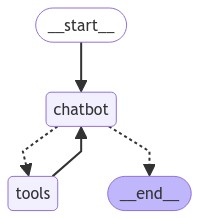

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 3.1.5 與聊天機器人互動

最後，我們創建一個簡單的交互界面，允許用戶與聊天機器人對話。


In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            # print("Assistant:", value["messages"][-1].content)
            value["messages"][-1].pretty_print()

User: 想知道高雄好吃的
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_BhCHEsTHA0ns8ofcr9IF7a3m)
 Call ID: call_BhCHEsTHA0ns8ofcr9IF7a3m
  Args:
    query: 高雄好吃的
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://tw.trip.com/blog/kaohsiung-food/", "content": "\u8981\u53bb\u9ad8\u96c4\u65c5\u904a\uff0c\u60f3\u627e\u597d\u5403\u7684\u9ad8\u96c4\u7f8e\u98df\u55ce\uff1f\u672c\u7bc7\u6587\u7ae0\u5c0f\u7de8\u5c07\u5e36\u5927\u5bb6\u4f86\u4e00\u8d9f\u9ad8\u96c4\u7684\u7f8e\u98df\u4e4b\u65c5\uff0c\u5e36\u4f60\u4e00\u8def\u5403\u904d\u9e7d\u57d5\u7f8e\u98df\u3001\u5de6\u71df\u7f8e\u98df\u3001\u5c0f\u6e2f\u7f8e\u98df\u3001\u6960\u6893\u7f8e\u98df\uff0c\u6574\u7bc7\u6587\u7ae0\u6574\u7406\u4e86\u5168\u9ad8\u96c4\u7684\u7f8e\u98df\u5fc5\u5403\u63a8\u85a6\uff0c\u8b93\u4f60\u4e00\u6b21\u5c07\u9ad8\u96c4\u7f8e\u98df\u5168\u90e8\u6536\u5230\u53e3\u88

這個循環允許用戶輸入消息，聊天機器人會處理這些輸入並給出回應。用戶可以隨時輸入 "quit"、"exit" 或 "q" 來結束對話。

### 3.1.6 總結

通過這個範例，我們展示了如何使用 LangGraph 構建一個具備網絡搜索能力的智能聊天機器人。這種方法不僅能處理基本的對話，還能在需要時獲取額外信息，大大提升了回應的質量和相關性。


# X. 參考資料：
1. Lang Chain Tool https://python.langchain.com/v0.2/docs/how_to/custom_tools/#creating-tools-from-functions
  - 觀念 https://python.langchain.com/v0.2/docs/concepts/#tools
2. LangChain Tool_calling https://python.langchain.com/v0.2/docs/how_to/tool_calling/
  - 觀念 https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling
  - 長篇 Blog https://blog.langchain.dev/tool-calling-with-langchain/
  - 結合 Message https://github.com/langchain-ai/langchain/blob/master/cookbook/tool_call_messages.ipynb
3. LangGRaph Tools Node: https://github.com/langchain-ai/langgraph/blob/main/examples/tool-calling.ipynb
  - 官方文件：https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent
4. Handle Tools node errors:https://github.com/langchain-ai/langgraph/blob/main/examples/tool-calling-errors.ipynb


建議閱讀順序：
1. Lang Chain Tool https://python.langchain.com/v0.2/docs/how_to/custom_tools/#creating-tools-from-functions
  - 觀念 https://python.langchain.com/v0.2/docs/concepts/#tools
2. LangChain Tool_calling https://python.langchain.com/v0.2/docs/how_to/tool_calling/
  - 觀念 https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling
  - 長篇 Blog https://blog.langchain.dev/tool-calling-with-langchain/
  - 結合 Message https://github.com/langchain-ai/langchain/blob/master/cookbook/tool_call_messages.ipynb
3. LangGRaph Tools Node: https://github.com/langchain-ai/langgraph/blob/main/examples/tool-calling.ipynb
  - 官方文件：https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent
4. Handle Tools node errors:https://github.com/langchain-ai/langgraph/blob/main/examples/tool-calling-errors.ipynb
4. LangGraph Tool_calling : https://langchain-ai.github.io/langgraph/how-tos/pass-run-time-values-to-tools/
4. Too_Calling Common Agentic Patterns: https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling

4. LangGraph Agent-executor :https://github.com/langchain-ai/langgraph/tree/main/examples/chat_agent_executor_with_function_calling
